In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from skimage.feature import graycomatrix, graycoprops
from skimage import data
import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import shape
import shapely
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



# Localized sandsnap texture generation from NAIP


Hypothesis:  VHR resolution satellite imagery (like NAIP) maybe good enough to see a correlation between image texture features (extracted from GLCMs) and sand grain size distribution


In this notebook, we extract median sand grain sizes (D50) from a single beach in NY, USA: Jones Beach. This beach has 52 observations spatially spread out across this beach taken in June 2021, and found in the file `data/sandsnap-jones-beach.csv`. Using the NAIP imagery from this beach, we will try to verify if there is a correlation b/w D50 and some GLCM features.

## Step 1

Extract SandSnap data to a pandas dataframe. Clean the dataframe, rename columns and drop unused columns

Clean the date format

In [2]:
sandsnap_df = pd.read_csv('../data/sandsnap-cont-usa.csv')
sandsnap_df['date'] =  pd.to_datetime(sandsnap_df['CreationDate'], format='%m/%d/%y',infer_datetime_format=True).dt.date
sandsnap_df.head()

,objectid,GlobalID,City,Sample ID,Coin Reference,Location on Beach,Other,CreationDate,Creator,EditDate,...,blurry_metric,ab_value,pixel_count,reprocess_record,reprocess_all_records,Calculated Grain Size,Analysis Status,x,y,date
0,925,fffbb2f3-562f-4ffa-8338-fe958bae327d,Gulfport,NaN,quarter,the_berm,NaN,11/12/22 14:16,NaN,11/12/22 14:18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-89.043261,30.377676,2022-11-12
1,261,de1184c4-f446-4e58-9016-94cdbd0cfc15,Ocean Beach,Ocean Beach #6,nickel,the_swash,NaN,9/15/21 15:16,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.511641,37.757227,2021-09-15
2,238,cf0a6f1c-b15d-4aa9-8ea6-55bba28b9d47,Key West,NaN,quarter,the_berm,NaN,9/15/21 15:16,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.809414,24.545279,2021-09-15
3,215,829ed0e3-ef7c-4286-99d0-1dab6575f449,St. Augustine,St. Augustine berm,quarter,the_berm,the_berm,9/14/21 18:51,rose.dopsovic,8/22/22 15:55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.264700,29.854100,2021-09-14
4,547,caf789b9-bcb9-46f5-8d71-64ee4e853e07,Racine,NaN,quarter,the_swash,NaN,5/3/22 16:05,NaN,5/3/22 16:12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.779766,42.739346,2022-05-03


In [3]:
sandsnap_df.dtypes

objectid                                                                                   int64
GlobalID                                                                                  object
City                                                                                      object
Sample ID                                                                                 object
Coin Reference                                                                            object
Location on Beach                                                                         object
Other                                                                                     object
CreationDate                                                                              object
Creator                                                                                   object
EditDate                                                                                  object
Editor                        

### Organize dataframe

In [31]:
usa = sandsnap_df[['objectid','D50 mm','Processing Status','date','x','y']]
usa = usa[usa['Processing Status'] == 'ok'].drop('Processing Status',axis='columns')
usa = usa.rename(columns={'D50 mm':'D50'}) #Rename the field
usa.head(), len(usa)

(   objectid       D50        date           x          y
 0       925  0.386369  2022-11-12  -89.043261  30.377676
 1       261  0.645732  2021-09-15 -122.511641  37.757227
 2       238  0.447742  2021-09-15  -81.809414  24.545279
 3       215  0.559148  2021-09-14  -81.264700  29.854100
 4       547  0.635700  2022-05-03  -87.779766  42.739346,
 644)

## Iterate over each entry and analyze

We will use a naive extraction method, which will be wasteful because these coordinates are likely to be covered by one or few NAIP tiles. But for the sake of simplicity, we will extract the NAIP tile that overlaps with each coordinate, and construct the texture features


In [30]:
side_len_deg = 0.0001 #~11.1m

In [32]:
def bbox(lon, lat, side_len_deg = 0.0001):
    point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    point_shape = shapely.geometry.shape(point_geom)
    #Create a square out of it with side_length = buffer*2
    mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
    aoi   = shapely.geometry.mapping(mask_shape)
    return aoi
    # return rasterio.features.bounds(aoi)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

## Functions to extract NAIP tiles for each entry

In [7]:
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [8]:
#returns the closest date 
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [34]:
def area_of_overlap(item, aoi):
    area_shape = shape(aoi)
    aoi_area = area_shape.area
    
    
    aoi_area = shape(aoi).area
    
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    # print(aoi_area, overlap_area)
    return overlap_area / aoi_area


def NAIP_tile(date, lon, lat, limit_months=60):
    
    #Create a window of limit_months around the acquisition date to search for NAIP data
    start_date, end_date = date - relativedelta(months=int(limit_months/2)), \
                            date + relativedelta(months=int(limit_months/2))


    range_date = "2018-01-01/2023-01-03"
    date_range = start_date.strftime('%Y-%m-%d') + "/" + end_date.strftime('%Y-%m-%d')
    
    aoi = bbox(lon, lat)

    search = stac.search(
        # bbox=aoi, 
        intersects=aoi,
        datetime=date_range,
        collections=["naip"],
        limit=5,
        #query={"eo:cloud_cover": {"lt": 25}},
    )

    items = search.item_collection()
    
    if len(items) == 0:
        print ("No tiles found in ", date_range)
        return None
    
    chosen_item = items[0]
    delta_days = abs((chosen_item.datetime.date() - date).days)
    
    if len(items) > 1:
        delta_min = 1e9
        
        #Choose the item that's closest in time to the sandsnap item's
        for i, item in enumerate(items):
            delta_days = abs((item.datetime.date() - date).days)
            # print(delta_days)
            if delta_days < delta_min:
                delta_min = delta_days
                chosen_item = item
                
    #Make sure area of overlap is 100%
    if area_of_overlap(chosen_item,aoi) != 1:
        return None
    
    print("{:} overlapping tile(s) found for date range: {:}\nChosen tile with delta:{:} days"\
      .format(len(items),date_range,delta_days))
        
    return chosen_item
        
        # chosen_item, aoo_max = items[0], 0.
        #Pick the tile that has the most amount of overlap with the coordinate patch
        # return sorted(items, key=area_of_overlap, reverse=True)[0]
    #     for i, item in enumerate(items):
    #         aoo = area_of_overlap(item, aoi)
    #         if aoo > aoo_max:
    #             aoo_max = aoo
    #             chosen_item = item
    #     return chosen_item
    # else:
    #     return items[0]
 

# Test

# tile = NAIP_tile(usa['date'][0],usa['x'][0],usa['y'][0])


# Crop of AOI

Efficiently!

In [10]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [26]:
import shapely 
import rasterio
from rasterio.mask import mask


def get_rgbir_patch(rgbir_url, lon, lat, window_size=3):
    """Returns the RGB-IR patch as a numpy, centered at lon,lat
    with a size of (window_size, window_size) pixels
    """
    point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    PATCH_SIZE_M = 100.
    # side_length_m = 101. #meters because the destination EPSG (26916) is in meters

    with rasterio.Env():
        with rasterio.open(rgbir_url, "r") as f:
            point_geom = rasterio.warp.transform_geom(
                "epsg:4326", f.crs.to_string(), point_geom)

            #Convert the point to a shape
            point_shape = shapely.geometry.shape(point_geom)
            #Create a square out of it with side_length = buffer*2
            mask_shape = point_shape.buffer(PATCH_SIZE_M/2).envelope
            mask_geom = shapely.geometry.mapping(mask_shape)

            #crop to the aoi (mask)
            try:
                image_rgbir, _ = mask(
                    f, [mask_geom], crop=True)
                
                #Now crop to a smaller patch
                assert (window_size < image_rgbir.shape[1])
                img_rgbir_patch = cropCenter(image_rgbir, (image_rgbir.shape[0],window_size,window_size)) #4 for 4 channels
                return img_rgbir_patch

            except ValueError as e:
                if "Input shapes do not overlap raster." in str(e):
                    print ("no dice")
                    return None
                    
                    
    


### Gray levels


Use of two methods to derive the gray levels from the 4 band image

In [12]:
def get_gray(img, method='mean'):
    """
    method:'mean' uses an average of all bands
    method:'weighted' uses known weights that maximuize human visual perception - probably not relevant for this task
    """
    
    gray = np.average(img, axis=0).astype('uint8') if method == 'mean' \
    else np.average(img, axis=0, weights=[0.3, 0.59, 0.11, 0.]).astype('uint8')
    
    return gray

## Haralick features

## Pick most appropriate NAIP tile
Sort them by area of coverage

Also remove some outliers

In [35]:
PROPERTIES = ['dissimilarity','homogeneity','contrast','energy','correlation']

#drop the first entry, aka outlier with D50 = 3.5mm
usa = usa.drop(usa.index[0]).reset_index(drop=True)
# test = usa.copy()

for prop in PROPERTIES:
    usa[prop] = np.NaN


usa.head()

,objectid,D50,date,x,y,dissimilarity,homogeneity,contrast,energy,correlation
0,261,0.645732,2021-09-15,-122.511641,37.757227,NaN,NaN,NaN,NaN,NaN
1,238,0.447742,2021-09-15,-81.809414,24.545279,NaN,NaN,NaN,NaN,NaN
2,215,0.559148,2021-09-14,-81.264700,29.854100,NaN,NaN,NaN,NaN,NaN
3,547,0.635700,2022-05-03,-87.779766,42.739346,NaN,NaN,NaN,NaN,NaN
4,378,0.668993,2021-10-17,-88.256353,42.350280,NaN,NaN,NaN,NaN,NaN


In [28]:
import warnings
warnings.filterwarnings("ignore")

def get_haralick_features(df):
    """
    """
    for index, sample in df.iterrows():
        # print(row['D50'], row['date'])
        lon, lat = sample['x'], sample['y']
        tile = NAIP_tile(sample['date'], lon, lat)
        if tile is None:
            continue
        
        gsd = tile.properties['gsd'] 
        window_size_px = int(WINDOW_SIZE_M / gsd + 0.5)
        # print(window_size_px)
        rgbir_url = tile.assets['image'].href

        #Extract patch of window_size_px around (lon,lat)
        patch = get_rgbir_patch(rgbir_url, lon, lat, window_size_px)
        
        if patch is None:
            continue

        #convert to grayscale
        gray = get_gray(patch)

        #get GLCM
        glcm = graycomatrix(gray, distances=[DISTANCE_PX], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                            symmetric=True, normed=False)

        #Get haralick features
        for prop in PROPERTIES:
            p = graycoprops(glcm, prop)
            p = np.average(p[0], axis=0)
            # print(p)
            df[prop].iloc[index] = p
    


In [57]:
WINDOW_SIZE_M = 5 #5m x 5m window
DISTANCE_PX = 1
# DISTANCE_PX = 5
# DISTANCE_PX = 10


get_haralick_features(usa)
usa.head()

1 overlapping tile(s) found for date range: 2019-03-15/2024-03-15
Chosen tile with delta:479 days
1 overlapping tile(s) found for date range: 2019-03-15/2024-03-15
Chosen tile with delta:657 days
1 overlapping tile(s) found for date range: 2019-03-14/2024-03-14
Chosen tile with delta:659 days
1 overlapping tile(s) found for date range: 2019-11-03/2024-11-03
Chosen tile with delta:608 days
1 overlapping tile(s) found for date range: 2019-04-17/2024-04-17
Chosen tile with delta:764 days
No tiles found in  2018-12-11/2023-12-11
1 overlapping tile(s) found for date range: 2018-12-11/2023-12-11
Chosen tile with delta:407 days
No tiles found in  2020-04-03/2025-04-03
1 overlapping tile(s) found for date range: 2019-05-18/2024-05-18
Chosen tile with delta:367 days
1 overlapping tile(s) found for date range: 2020-03-15/2025-03-15
Chosen tile with delta:863 days
1 overlapping tile(s) found for date range: 2019-03-14/2024-03-14
Chosen tile with delta:486 days
1 overlapping tile(s) found for date

,objectid,D50,date,x,y,dissimilarity,homogeneity,contrast,energy,correlation
0,261,0.645732,2021-09-15,-122.511641,37.757227,13.869898,0.201101,612.165816,0.116101,0.828247
1,238,0.447742,2021-09-15,-81.809414,24.545279,1.670281,0.507122,6.338648,0.237626,0.555067
2,215,0.559148,2021-09-14,-81.264700,29.854100,1.017219,0.584390,1.975128,0.215778,0.814251
3,547,0.635700,2022-05-03,-87.779766,42.739346,1.224490,0.534370,2.919643,0.295792,0.521678
4,378,0.668993,2021-10-17,-88.256353,42.350280,1.801020,0.397562,5.234694,0.157132,0.789451


## Multiple regression

In [58]:
usa

,objectid,D50,date,x,y,dissimilarity,homogeneity,contrast,energy,correlation
0,261,0.645732,2021-09-15,-122.511641,37.757227,13.869898,0.201101,612.165816,0.116101,0.828247
1,238,0.447742,2021-09-15,-81.809414,24.545279,1.670281,0.507122,6.338648,0.237626,0.555067
2,215,0.559148,2021-09-14,-81.264700,29.854100,1.017219,0.584390,1.975128,0.215778,0.814251
3,547,0.635700,2022-05-03,-87.779766,42.739346,1.224490,0.534370,2.919643,0.295792,0.521678
4,378,0.668993,2021-10-17,-88.256353,42.350280,1.801020,0.397562,5.234694,0.157132,0.789451
...,...,...,...,...,...,...,...,...,...,...
638,100,1.205290,2021-06-11,-73.561078,40.578827,0.153061,0.923469,0.153061,0.705113,0.635208
639,984,0.198888,2022-11-21,-79.773942,32.790679,NaN,NaN,NaN,NaN,NaN
640,492,0.473989,2022-03-09,-119.194608,34.140937,3.563138,0.262695,21.995536,0.126068,0.595965
641,1033,0.807466,2022-11-29,-76.225683,34.922580,1.350765,0.466787,2.845663,0.239841,0.109836


### Remove all NaNs

In [59]:
df = usa[usa['dissimilarity'].notna()].reset_index()
df

,index,objectid,D50,date,x,y,dissimilarity,homogeneity,contrast,energy,correlation
0,0,261,0.645732,2021-09-15,-122.511641,37.757227,13.869898,0.201101,612.165816,0.116101,0.828247
1,1,238,0.447742,2021-09-15,-81.809414,24.545279,1.670281,0.507122,6.338648,0.237626,0.555067
2,2,215,0.559148,2021-09-14,-81.264700,29.854100,1.017219,0.584390,1.975128,0.215778,0.814251
3,3,547,0.635700,2022-05-03,-87.779766,42.739346,1.224490,0.534370,2.919643,0.295792,0.521678
4,4,378,0.668993,2021-10-17,-88.256353,42.350280,1.801020,0.397562,5.234694,0.157132,0.789451
...,...,...,...,...,...,...,...,...,...,...,...
491,636,200,0.543331,2021-09-14,-75.625280,35.958540,7.395408,0.199608,129.551020,0.114781,0.839584
492,637,933,0.796215,2022-11-12,-88.991293,30.388766,1.242347,0.524389,2.818878,0.208525,0.806909
493,638,100,1.205290,2021-06-11,-73.561078,40.578827,0.153061,0.923469,0.153061,0.705113,0.635208
494,640,492,0.473989,2022-03-09,-119.194608,34.140937,3.563138,0.262695,21.995536,0.126068,0.595965


In [60]:
import statsmodels.formula.api as smf 

# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ dissimilarity + homogeneity + contrast + correlation + energy', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3.438
Date:                Sun, 12 Mar 2023   Prob (F-statistic):            0.00460
Time:                        02:48:34   Log-Likelihood:                -97.012
No. Observations:                 496   AIC:                             206.0
Df Residuals:                     490   BIC:                             231.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7186      0.111      6.499      0.000       0.501       0.936
dissimilarity    -0.0163      0.016     -1.003      0.316      -0.048       0.016
homogeneity      -0.1310      0.257     -0.510      0.610      -0.636       0.374
contrast      -2.746e-05      0.000     -0.094      0.926      -0.001       0.001
correlation       0.0697      0.066      1.052      0.293      -0.060       0.200
energy           -0.0139      0.247     -0.056      0.955      -0.499       0.471
==============================================================================
Omnibus:                      356.402   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9862.692
Skew:                           2.735   Prob(JB):                         0.00
Kurtosis:                      24.150   Cond. No.                     4.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     11.20
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           0.000882
Time:                        02:48:47   Log-Likelihood:                -100.00
No. Observations:                 496   AIC:                             204.0
Df Residuals:                     494   BIC:                             212.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6746      0.018     38.417      0.000       0.640       0.709
dissimilarity    -0.0106      0.003     -3.346      0.001      -0.017      -0.004
==============================================================================
Omnibus:                      346.922   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9004.571
Skew:                           2.649   Prob(JB):                         0.00
Kurtosis:                      23.190   Cond. No.                         7.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='dissimilarity', ylabel='D50'>

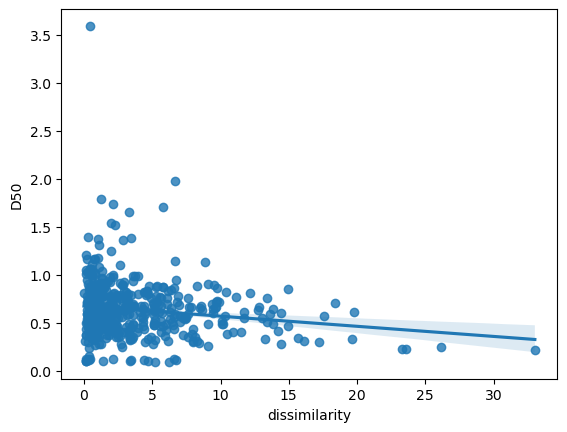

In [61]:
model_dis = smf.ols(formula='D50 ~ dissimilarity', data=df).fit()
display(model_dis.summary())
sns.regplot(x='dissimilarity', y='D50', data=df)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.010
Date:                Sun, 12 Mar 2023   Prob (F-statistic):              0.315
Time:                        02:49:06   Log-Likelihood:                -105.06
No. Observations:                 496   AIC:                             214.1
Df Residuals:                     494   BIC:                             222.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6113      0.028     21.612      0.000       0.556       0.667
homogeneity     0.0561      0.056      1.005      0.315      -0.054       0.166
==============================================================================
Omnibus:                      344.318   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8646.420
Skew:                           2.632   Prob(JB):                         0.00
Kurtosis:                      22.765   Cond. No.                         5.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='homogeneity', ylabel='D50'>

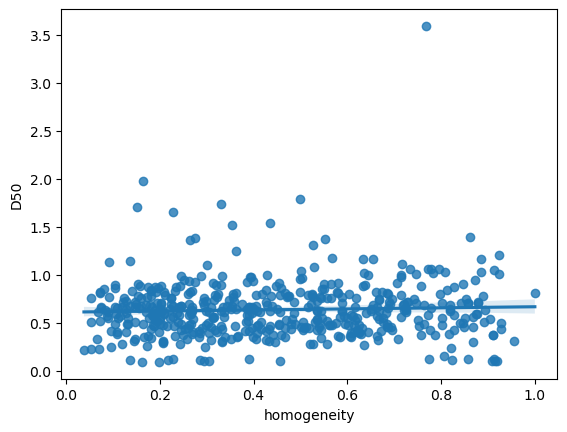

In [62]:
model_hom = smf.ols(formula='D50 ~ homogeneity', data=df).fit()
display(model_hom.summary())
sns.regplot(x='homogeneity', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     13.75
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           0.000232
Time:                        02:49:08   Log-Likelihood:                -98.754
No. Observations:                 496   AIC:                             201.5
Df Residuals:                     494   BIC:                             209.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6555      0.014     45.967      0.000       0.627       0.684
contrast      -0.0003   8.17e-05     -3.708      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      351.341   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9449.266
Skew:                           2.687   Prob(JB):                         0.00
Kurtosis:                      23.697   Cond. No.                         187.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='contrast', ylabel='D50'>

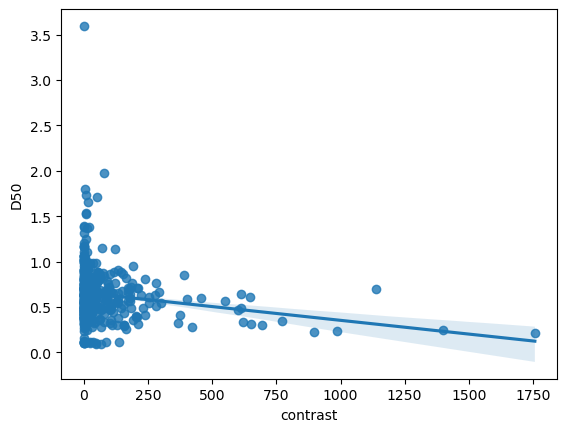

In [63]:
model_con = smf.ols(formula='D50 ~ contrast', data=df).fit()
display(model_con.summary())
sns.regplot(x='contrast', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7736
Date:                Sun, 12 Mar 2023   Prob (F-statistic):              0.380
Time:                        02:49:09   Log-Likelihood:                -105.18
No. Observations:                 496   AIC:                             214.4
Df Residuals:                     494   BIC:                             222.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6060      0.037     16.386      0.000       0.533       0.679
correlation     0.0525      0.060      0.880      0.380      -0.065       0.170
==============================================================================
Omnibus:                      348.768   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8945.207
Skew:                           2.675   Prob(JB):                         0.00
Kurtosis:                      23.105   Cond. No.                         5.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='correlation', ylabel='D50'>

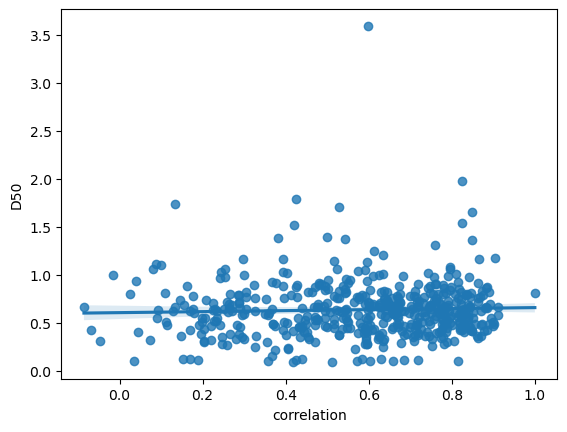

In [64]:
model_corr = smf.ols(formula='D50 ~ correlation', data=df).fit()
display(model_corr.summary())
sns.regplot(x='correlation', y='D50', data=df)
# plt.scatter(usa['correlation'], usa['D50'])
# plt.plot(model_corr,linestyle ='dotted')
# plt.xlabel('correlation')
# plt.ylabel('D50')
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.001619
Date:                Sun, 12 Mar 2023   Prob (F-statistic):              0.968
Time:                        02:49:10   Log-Likelihood:                -105.56
No. Observations:                 496   AIC:                             215.1
Df Residuals:                     494   BIC:                             223.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6355      0.024     26.530      0.000       0.588       0.683
energy         0.0032      0.080      0.040      0.968      -0.155       0.161
==============================================================================
Omnibus:                      347.191   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8901.278
Skew:                           2.657   Prob(JB):                         0.00
Kurtosis:                      23.062   Cond. No.                         6.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='energy', ylabel='D50'>

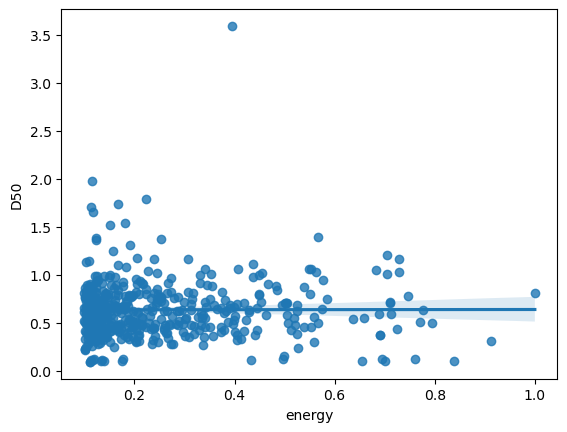

In [65]:
model_energy = smf.ols(formula='D50 ~ energy', data=df).fit()
display(model_energy.summary())
sns.regplot(x='energy', y='D50', data=df)

# Closing Notes

Clearly no linearity can be found at these spatial scale (0.6m). This is likely telling us that the texture features are all but lost at this resolution for detecting particle sizes of this size (<2mm)